In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
plt.rcParams.update({'font.size': 14})

# Data

In [2]:
# import data
counts_1ml = np.genfromtxt("linearity_counts.csv", delimiter=",", skip_header=1, usecols=[2,3,4], max_rows=352)
# columns: deadtime factor, CPM, deadtime-corrected CPM

time = np.genfromtxt("linearity_counts.csv", dtype='datetime64', delimiter=",", skip_header=1, usecols=[0], max_rows=352)
time_in_seconds = time.astype('datetime64[s]').astype('int')
time_in_seconds = time_in_seconds - time_in_seconds[0] + 1

# for now let's just assume background cpm = 40
counts_1ml[:, 1:3] = counts_1ml[:, 1:3] - 55

## Backgrounds

In [3]:
# done in excel

# Old version: Counts of 1 mL vials

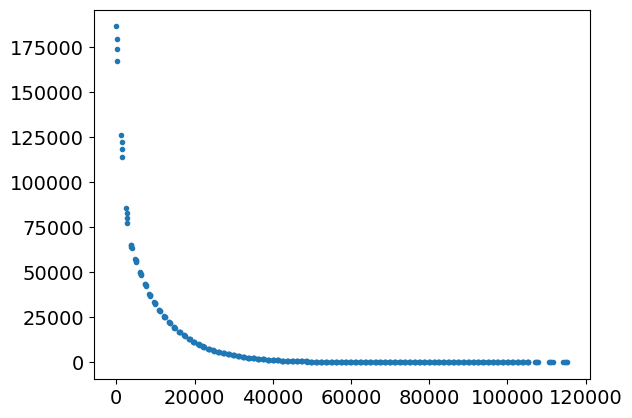

In [3]:
# make artificial data starting with an activity of 1
T = 109.7 # half life in minutes
T = T*60

A_0 = 1
c = 0.693/T
A = A_0*np.exp(c*time_in_seconds) # produce the fake data backwards since lower points are more reliable
A = A[::-1]

plt.plot(time_in_seconds, A, ".")

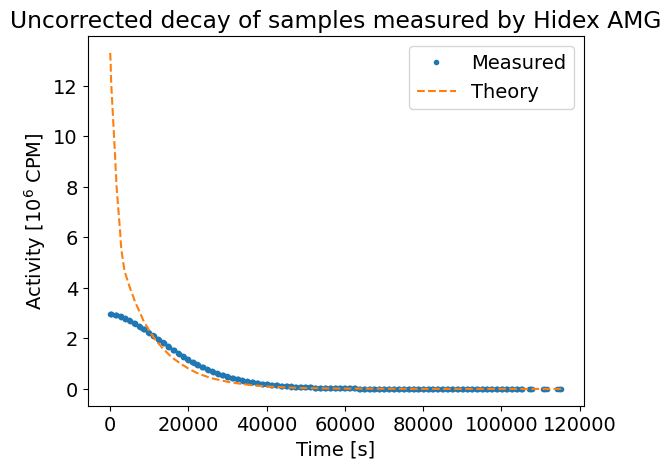

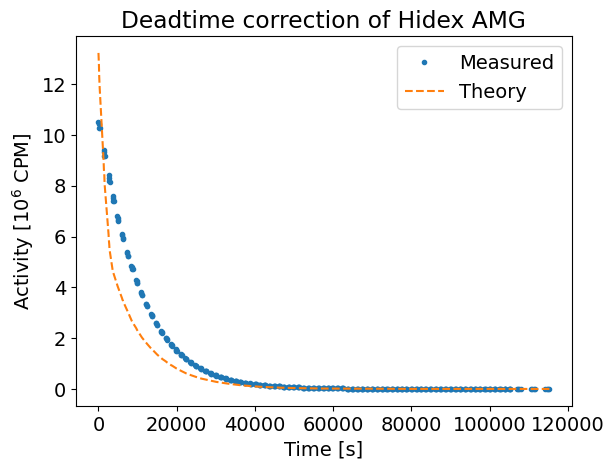

In [4]:
plt.plot(time_in_seconds, counts_1ml[:, 1]/1e6, ".", label="Measured")
plt.plot(time_in_seconds, A*min(counts_1ml[:, 1])/1e6, "--", label="Theory")
plt.title("Uncorrected decay of samples measured by Hidex AMG")
plt.xlabel("Time [s]")
plt.ylabel("Activity [10$^6$ CPM]")
plt.legend()

plt.figure()
plt.title("Deadtime correction of Hidex AMG")
plt.xlabel("Time [s]")
plt.ylabel("Activity [10$^6$ CPM]")
plt.plot(time_in_seconds, counts_1ml[:, 2]/1e6, ".", label="Measured")
plt.plot(time_in_seconds, A*min(counts_1ml[:, 2])/1e6, "--", label="Theory")
plt.legend()
plt.show()

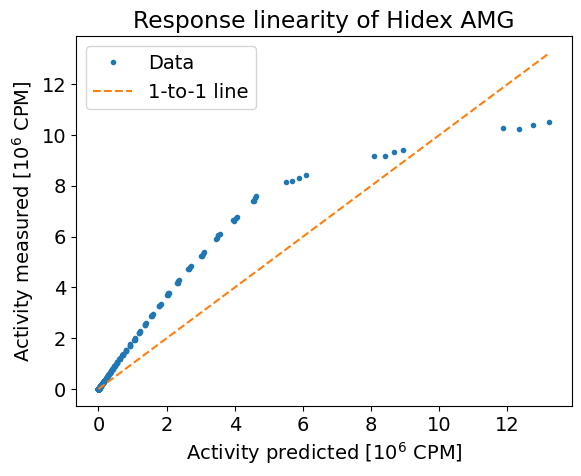

In [5]:
plt.figure()
plt.title("Response linearity of Hidex AMG")
plt.xlabel("Activity predicted [10$^6$ CPM]")
plt.ylabel("Activity measured [10$^6$ CPM]")
plt.plot(A*min(counts_1ml[:, 2])/1e6, counts_1ml[:, 2]/1e6, ".", label="Data")

x = np.linspace(min(A*min(counts_1ml[:, 2])/1e6), max(A*min(counts_1ml[:, 2])/1e6), 100)
plt.plot(x,x, "--", label="1-to-1 line")
plt.legend()
plt.show()

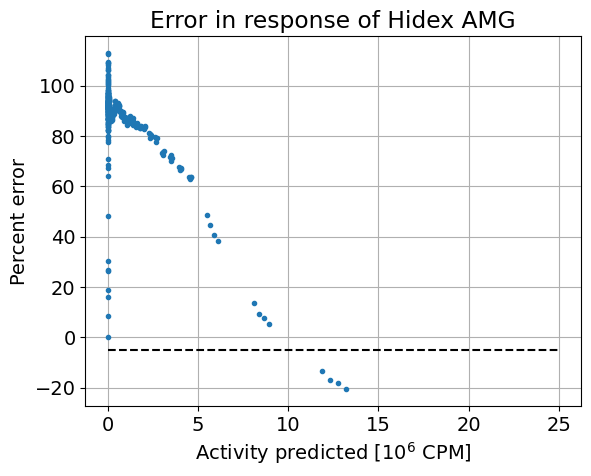

In [6]:
plt.figure()
plt.title("Error in response of Hidex AMG")
plt.xlabel("Activity predicted [10$^6$ CPM]")
plt.ylabel("Percent error")
predicted = A*min(counts_1ml[:, 2])/1e6
resid = (counts_1ml[:, 2]/1e6 - predicted)/predicted * 100
plt.plot(predicted, resid, ".")

plt.hlines(-5, 0 , 25, "k", linestyle="--")

plt.grid()
plt.show()

## What the hell is going on at low activities??

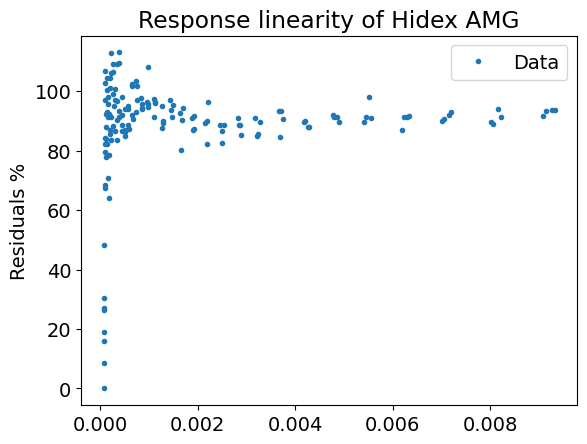

In [7]:
plt.figure()
plt.title("Response linearity of Hidex AMG")
plt.ylabel("Residuals %")
end = 200
plt.plot(predicted[end:], resid[end:], ".", label="Data")

#x = np.linspace(min(A*min(counts_1ml[:end, 2])/1e6), max(A[:end]*min(counts_1ml[:end, 2])/1e6), 100)
#plt.plot(x,x, "--", label="1-to-1 line")
plt.legend()
plt.show()

# New version: Fit the lower half of the data to an exponential
This version of the code yields the qualitative behavior we expect.

[83.13125541 11.93291886]


array([8344579.02601175,  100399.2321251 ])

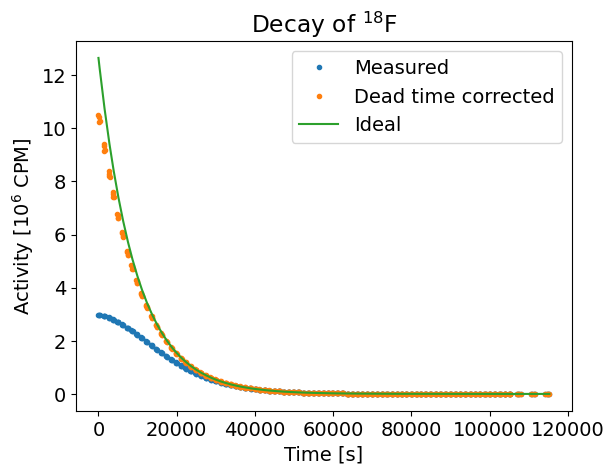

In [3]:
from scipy.optimize import curve_fit

def decay(t, N0, k):
    T = 109.7 # half life in minutes
    T = T*60
    c = 0.693/T
    return N0*np.exp(-c*t + k)

start = 120
p = curve_fit(decay, time_in_seconds[start:], counts_1ml[start:, 2])

# tidy up plots
plt.plot(time_in_seconds, counts_1ml[:, 1]/1e6, ".", label="Measured")
plt.plot(time_in_seconds, counts_1ml[:, 2]/1e6, ".", label="Dead time corrected")
plt.plot(time_in_seconds, decay(time_in_seconds, p[0][0], p[0][1])/1e6, label="Ideal")
plt.ylabel("Activity [10$^6$ CPM]")
plt.xlabel("Time [s]")
plt.title("Decay of $^{18}$F")

plt.legend()
print(p[0])
perr = np.sqrt(np.diag(p[1]))
perr

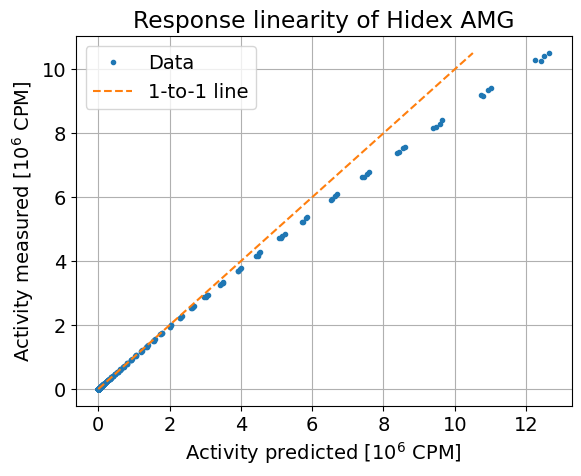

In [4]:
# next: redo the linearity plot
plt.figure()
plt.title("Response linearity of Hidex AMG")
plt.xlabel("Activity predicted [10$^6$ CPM]")
plt.ylabel("Activity measured [10$^6$ CPM]")

predicted = decay(time_in_seconds, p[0][0], p[0][1])
plt.plot(predicted/1e6, counts_1ml[:, 2]/1e6, ".", label="Data")

x = np.linspace(min(counts_1ml[:, 2]/1e6), max(counts_1ml[:, 2]/1e6), 100)
plt.plot(x,x, "--", label="1-to-1 line")
plt.grid()
plt.legend()
plt.show()

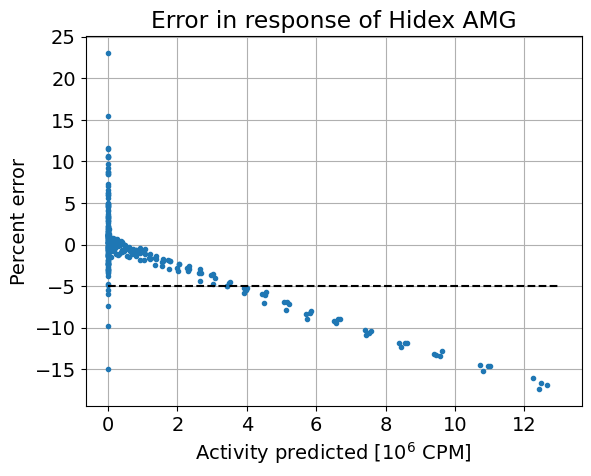

In [5]:
plt.figure()
plt.title("Error in response of Hidex AMG")
plt.xlabel("Activity predicted [10$^6$ CPM]")
plt.ylabel("Percent error")

resid = (counts_1ml[:, 2]/1e6 - predicted/1e6)/(predicted/1e6) * 100
plt.plot(predicted/1e6, resid, ".")

plt.hlines(-5, 0 , 13, "k", linestyle="--")

plt.grid()
plt.show()

[-1.36296796 -0.09503192]


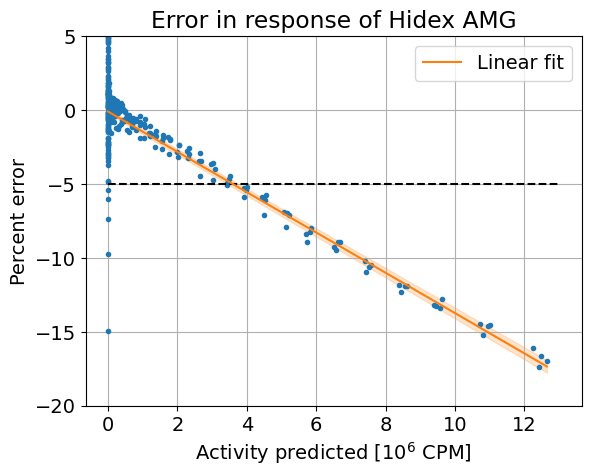

In [6]:
plt.figure()
plt.title("Error in response of Hidex AMG")
plt.xlabel("Activity predicted [10$^6$ CPM]")
plt.ylabel("Percent error")

resid = (counts_1ml[:, 2]/1e6 - predicted/1e6)/(predicted/1e6) * 100
plt.plot(predicted/1e6, resid, ".")

plt.hlines(-5, 0 , 13, "k", linestyle="--")
plt.ylim(-20, 5)

plt.grid()

# linear best-fit to find what activity corresponds to a 5% error
start = 50
b, cov = np.polyfit(predicted[:start]/1e6, resid[:start], 1, cov = True)
plt.plot((predicted)/1e6, (b[0]*predicted/1e6 + b[1]), label="Linear fit")

perr = np.sqrt(np.diag(cov))
print(b)
x = (predicted)/1e6
y_plus = (b[0]+perr[0])*predicted/1e6 + b[1]+perr[1]
y_minus = (b[0]-perr[0])*predicted/1e6 + b[1]-perr[1]
plt.fill_between(x, y_minus, y_plus, alpha=0.2, color='C1')

plt.legend()
plt.show()

In [9]:
# calculate the activity at 5%
# activity "x" for which b[0]*x + b[1] = -5

max_CPM = (-5 - b[1])/b[0] # in 10^6 CPM
print("10^6 CPM at 5% error: ", max_CPM)

eff = 0.46 # from hidex manual
max_activity = max_CPM/eff 
print("theoretical activity at 5% error: ", max_activity*1e6/60) # in bq

error_on_cpm = max_CPM - (-5 - (b[1]+perr[1]))/(b[0]+perr[0])
print("Error on above CPM estimation: ", error_on_cpm)

10^6 CPM at 5% error:  3.5987405581447702
theoretical activity at 5% error:  130389.1506574192
Error on above CPM estimation:  -0.16883992279355997


[-6.81942025  6.62103208]
[0.11628878 0.27687852]


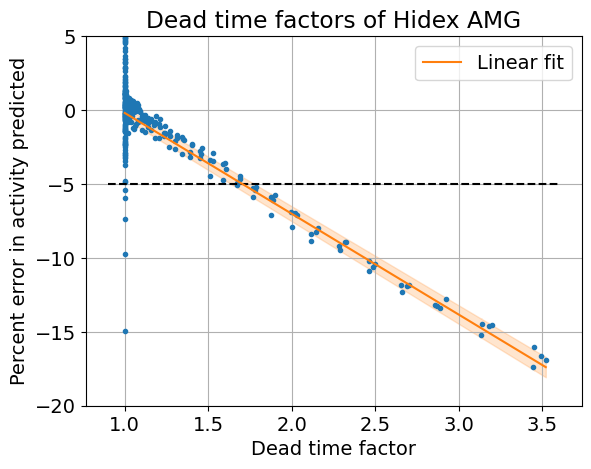

1.7041085092829582
-0.07086944687651031


In [10]:
# correlate percent error in the activity to the deadtime factor

dt = counts_1ml[:,0]

plt.figure()
plt.title("Dead time factors of Hidex AMG")
plt.xlabel("Dead time factor")
plt.ylabel("Percent error in activity predicted")

resid = (counts_1ml[:, 2]/1e6 - predicted/1e6)/(predicted/1e6) * 100
plt.plot(dt, resid, ".")

plt.hlines(-5, 0.9 , 3.6, "k", linestyle="--")
plt.ylim(-20, 5)

plt.grid()

# linear best-fit to find what activity corresponds to a 5% error
start = 50
b, cov = np.polyfit(dt[:start], resid[:start], 1, cov = True)
plt.plot(dt, (b[0]*dt + b[1]), label="Linear fit")
print(b)
perr = np.sqrt(np.diag(cov))
print(perr)
x = dt
y_plus = (b[0]+perr[0])*dt + b[1]+perr[1]
y_minus = (b[0]-perr[0])*dt + b[1]-perr[1]
plt.fill_between(x, y_minus, y_plus, alpha=0.2, color='C1')

plt.legend()
plt.show()

max_dt = (-5 - b[1])/b[0] # deadtime at 5%
print(max_dt)

error_on_dt = max_dt - (-5 - (b[1]+perr[1]))/(b[0]+perr[0])
print(error_on_dt)

# Calculating the deadtime factors for given percent error

In [14]:
def calculate_dt(percent_error, fit_params, err_fit_params):
    
    dt = (-percent_error - fit_params[1])/fit_params[0]
    error_on_dt = max_dt - (-percent_error - (fit_params[1]+err_fit_params[1]))/(fit_params[0]+err_fit_params[0])
    
    return dt, error_on_dt

In [15]:
for p_err in [ 1, 3, 5, 10, 30]:
    print(calculate_dt(p_err, b, perr))

(1.1175483838184537, 0.5258665736035784)
(1.410828446550706, 0.22749856336353402)
(1.7041085092829582, -0.07086944687651031)
(2.437308666113589, -0.8167894724766214)
(5.370109293436112, -3.8004695748770643)
